In [1]:
# Using Poetry there is no need to install these packages
%pip install scikit-learn
%pip install tree-sitter tree-sitter-python tree-sitter-typescript tree_sitter_javascript tree-sitter-go
%pip install jupyterlab notebook
%pip install pandas matplotlib ipywidgets ipympl

!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/Users/usuario/Library/Caches/pypoetry/virtualenvs/setrem-developer-demo-DzSENT3G-py3.11/lib/python3.11/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/Users/usuario/Library/Caches/pypoetry/virtualenvs/setrem-developer-demo-DzSENT3G-py3.11/lib/python3.11/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Nod

Copy data from S3 to local

In [4]:
!aws s3 cp s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318 ./tmp_data --recursive

download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Android/android.py to tmp_data/cpython/Android/android.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Doc/includes/email-headers.py to tmp_data/cpython/Doc/includes/email-headers.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Android/testbed/app/src/main/python/main.py to tmp_data/cpython/Android/testbed/app/src/main/python/main.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Doc/includes/email-alternative.py to tmp_data/cpython/Doc/includes/email-alternative.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Doc/conf.py to tmp_data/cpython/Doc/conf.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Doc/includes/dbpickle.py to tmp_data/cpython/Doc/includes/dbpickle.py
download: s3://repositories-edc1c5c1-1a23-4ca7-8458-4d70b4646318/cpython/Doc/includes/email-dir.py to tmp_data/cpy

Load data

In [3]:
import os
import tree_sitter_python
import tree_sitter_go
import tree_sitter_javascript

from tree_sitter import Language, Parser

PY_LANG = Language(tree_sitter_python.language())
GO_LANG = Language(tree_sitter_go.language())
TS_LANG = Language(tree_sitter_javascript.language())

nodes_to_ignore = []

def read_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
        return file_path, content
    except Exception as e:
        return file_path, f"Error reading file: {str(e)}"

def collect_tokens(node, source_code, tokens, depth=0):
    if node.child_count == 0:
        if node.type not in nodes_to_ignore:
            start_byte = node.start_byte
            end_byte = node.end_byte
            token = source_code[start_byte:end_byte].decode("utf-8")
            tokens.append((node.type, token, depth))
    else:
        for child in node.children:
            collect_tokens(child, source_code, tokens, depth+1)

def load_source_code_files(directory):
    valid_extensions = ['.go', '.py', '.ts']
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in valid_extensions):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
    return file_paths

def count_file_types_class(files):
    file_types = {}
    for f in files:
        extension = f.split(".")[-1]
        if extension not in file_types:
            file_types[extension] = 0
        file_types[extension] += 1
    return file_types

Gettings files from local data

In [4]:
data_path = './tmp_data'
data_files = load_source_code_files(directory = data_path)
data_files[:10]

['./tmp_data/go/misc/ios/detect.go',
 './tmp_data/go/misc/ios/go_ios_exec.go',
 './tmp_data/go/misc/cgo/gmp/gmp.go',
 './tmp_data/go/misc/cgo/gmp/fib.go',
 './tmp_data/go/misc/cgo/gmp/pi.go',
 './tmp_data/go/misc/linkcheck/linkcheck.go',
 './tmp_data/go/misc/go_android_exec/exitcode_test.go',
 './tmp_data/go/misc/go_android_exec/main.go',
 './tmp_data/go/test/rename.go',
 './tmp_data/go/test/recover2.go']

In [5]:
len(data_files), count_file_types_class(data_files)

(1500, {'go': 500, 'py': 500, 'ts': 500})

Test parser for one file

In [7]:
file = read_file(file_path = './tmp_data/go/misc/ios/go_ios_exec.go')
test_go_parser = Parser(language = GO_LANG)
tree = test_go_parser.parse(
    bytes(
        file[1],
        "utf-8"
    )
)

tokens = []
collect_tokens(
    node = tree.root_node,
    source_code = file[1].encode("utf-8"),
    tokens = tokens 
)

tokens[:10]

[('comment', '// Copyright 2024 The Go Authors. All rights reserved.', 1),
 ('comment', '// Use of this source code is governed by a BSD-style', 1),
 ('comment', '// license that can be found in the LICENSE file.', 1),
 ('comment',
  '// This program can be used as go_ios_$GOARCH_exec by the Go tool. It executes',
  1),
 ('comment', '// binaries on the iOS Simulator using the XCode toolchain.', 1),
 ('package', 'package', 2),
 ('package_identifier', 'main', 2),
 ('\n', '\n\n', 1),
 ('import', 'import', 2),
 ('(', '(', 3)]

Parse all files using vectorized

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import lru_cache


extension_map_tokenizer = {
    'go': GO_LANG,
    'py': PY_LANG,
    'ts': TS_LANG
}

@lru_cache(maxsize=None)
def tokenizer(file):
    file_content = read_file(file_path = file)[1]
    file_extension = file.split('.')[-1]
    language = extension_map_tokenizer[file_extension]
    parser = Parser(language = language)
    tree = parser.parse(
        bytes(
            file_content,
            "utf-8"
        )
    )
    tokens = []
    collect_tokens(
        node = tree.root_node,
        source_code = file_content.encode("utf-8"),
        tokens = tokens
    )
    node_types = [x[0] for x in tokens ]
    return node_types


vectorizer = TfidfVectorizer(
    tokenizer = tokenizer
)

In [17]:
features = vectorizer.fit_transform(raw_documents = data_files)
print(f'Samples {features.shape[0]}, feature: {features.shape[1]}')

/Users/usuario/Library/Caches/pypoetry/virtualenvs/setrem-developer-demo-DzSENT3G-py3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Samples 1500, feature: 180


In [18]:
vectorizer.get_feature_names_out()

array(['\n', '!', '!=', '!==', '"', '${', '%', '%=', '&', '&&', '&=',
       '&^', '&^=', "'", '(', ')', '*', '**', '**=', '*=', '+', '++',
       '+=', ',', '-', '--', '-=', '->', '.', '...', '/', '//', '//=',
       '/=', '/>', ':', ':=', ';', '<', '<-', '<<', '<<=', '<=', '=',
       '==', '===', '=>', '>', '>=', '>>', '>>=', '?', '??', '@', '@=',
       'ERROR', '[', ']', '^', '^=', '_', '__future__', '`', 'and', 'as',
       'assert', 'async', 'await', 'blank_identifier', 'block', 'break',
       'case', 'catch', 'chan', 'class', 'comment', 'const', 'continue',
       'def', 'default', 'defer', 'del', 'delete', 'elif', 'ellipsis',
       'else', 'escape_interpolation', 'escape_sequence', 'except',
       'export', 'extends', 'fallthrough', 'false', 'field_identifier',
       'finally', 'float', 'float_literal', 'for', 'from', 'func',
       'function', 'get', 'global', 'go', 'goto', 'identifier', 'if',
       'imaginary_literal', 'import', 'in', 'instanceof', 'int_literal',
      

Apply K-Means

In [109]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(
    n_clusters = k,
    n_init = 10,
    random_state = 1
)
clusters = kmeans.fit_predict(features)

cluster_results = {}
for i in range(k):
    if i not in cluster_results:
        cluster_results[i] = []
    cluster_results[i].extend([data_files[j] for j in range(len(data_files)) if clusters[j] == i])

for k, v in cluster_results.items():
    print(f"cluster: {k}, result: {count_file_types_class(v)}")

cluster: 0, result: {'go': 1, 'py': 494, 'ts': 4}
cluster: 1, result: {'ts': 496}
cluster: 2, result: {'go': 499, 'py': 6}


Visualization

In [114]:
from sklearn.decomposition import PCA

number_of_features_to_reduce = 3
pca = PCA(n_components = number_of_features_to_reduce)
reduced_data = pca.fit_transform(features.toarray())
print(f'Samples {reduced_data.shape[0]}, feature: {reduced_data.shape[1]}')

Samples 1500, feature: 3


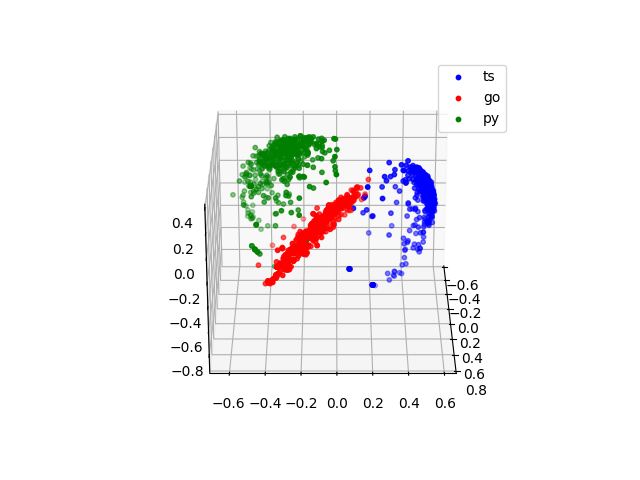

In [136]:
%matplotlib widget

import matplotlib.pyplot as plt

figure = plt.figure()
ax = figure.add_subplot(111, projection="3d")

colors = ["blue", "red", "green"]
cluster_names = ["ts", "go", "py"]

for i in range(len(colors)):
    ax.scatter(
        reduced_data[kmeans.labels_ == i, 0],  # x
        reduced_data[kmeans.labels_ == i, 1],  # y
        reduced_data[kmeans.labels_ == i, 2],  # z
        color = colors[i],
        s = 10,
        label = cluster_names[i]
    )

ax.view_init(azim = 0, elev = 25)
plt.legend()
plt.show()

Testing the classification of a new file (using the trained model)
It must classify the code between GO, PY or TS

In [150]:
data_test = './dataset-for-test/'
test_files = load_source_code_files(directory = data_test)

len(test_files), count_file_types_class(test_files)

(2, {'py': 1, 'go': 1})

In [151]:
# Using the same vectorizer
test_features = vectorizer.transform(
    raw_documents = test_files
)
test_features.shape

(2, 180)

In [152]:
test_clusters = kmeans.predict(test_features)
# For each file, print the cluster
test_clusters

array([0, 2], dtype=int32)